In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
df = pd.read_csv('fifa_players.csv')

In [57]:
df.columns

Index(['name', 'full_name', 'birth_date', 'age', 'height_cm', 'weight_kgs',
       'positions', 'nationality', 'overall_rating', 'potential', 'value_euro',
       'wage_euro', 'preferred_foot', 'international_reputation(1-5)',
       'weak_foot(1-5)', 'skill_moves(1-5)', 'body_type',
       'release_clause_euro', 'national_team', 'national_rating',
       'national_team_position', 'national_jersey_number', 'crossing',
       'finishing', 'heading_accuracy', 'short_passing', 'volleys',
       'dribbling', 'curve', 'freekick_accuracy', 'long_passing',
       'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions',
       'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
       'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
       'composure', 'marking', 'standing_tackle', 'sliding_tackle'],
      dtype='object')

In [58]:
# Drop columns identified as "To-drop" except name and full_name (which will be dropped in cell 8)
columns_to_drop = [
    'name',
    'full_name',
    'birth_date',
    'nationality',
    'national_team',
    'national_rating',
    'national_team_position',
    'national_jersey_number',
    'height_cm',
    'preferred_foot',
    'body_type',
    'overall_rating',
    'potential',
    'reactions',
    'weak_foot(1-5)',
    'international_reputation(1-5)',
    'skill_moves(1-5)',
    'release_clause_euro',
    'wage_euro',
    'ball_control'
]

# Drop the columns
df.drop(columns=columns_to_drop, inplace=True)

In [59]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

df['value_euro'] = imputer.fit_transform(df[['value_euro']])

In [60]:
print(df['value_euro'].isna().sum())  # Check if there are any missing values left
y = df['value_euro']
print(y.isna().sum())

0
0


Ordinal(comparable):
1. none


Nominal (incomparable):
1. positions
2. nationality
3. preferred_foot
4. body_type

To-drop:
1. name
2. full_name
3. birth_date
4. national_team
5. national_rating
6. national_team_position
7. natinoal_jersey_number

Reason - we don't need players' personal data, only their stats. 
Additionally, we need to ignore national team stats, because we can assume that the players' performance can vary drastically due to playing on a different position.

In [61]:
X = df.copy()
y = df['value_euro']

We have splitted dependend and independend variables on 'X' and y.
As a target parameter, we have chosen 'value_euro'

In [62]:
a = set(X['positions'].unique())
b = list(a)
unique_positions = []
for p in b:
    tmp = list(p.split(','))
    for i in tmp:
        if i not in unique_positions:
            unique_positions.append(i)
print("Unique positions: " + str(unique_positions))
print("Number of unique positions: " + str(len(unique_positions)))

for position in unique_positions:
    X[position] = X['positions'].apply(lambda x: 1 if position in x else 0)

X.drop(columns=['positions'], inplace=True)

Unique positions: ['RW', 'CAM', 'RM', 'CB', 'RB', 'LM', 'CF', 'LB', 'RWB', 'CDM', 'CM', 'ST', 'LW', 'LWB', 'GK']
Number of unique positions: 15


Encoded positions onto unique positions

In [63]:
attackers = ['ST', 'CF', 'LW', 'RW']
midfielders = ['CAM', 'CM', 'CDM', 'LM', 'RM']
defenders = ['CB', 'LB', 'RB', 'LWB', 'RWB']
goalies = ['GK']

X['attacker'] = X[attackers].max(axis=1)
X['midfielder'] = X[midfielders].max(axis=1)
X['defender'] = X[defenders].max(axis=1)
X['goalie'] = X[goalies].max(axis=1)

X = X.drop(attackers + midfielders + defenders + goalies, axis=1)
df2 = X.copy()
X.drop(columns=['value_euro'], inplace=True)

In [64]:
#Resolve outliers

Q1 = y.quantile(0.15)
Q3 = y.quantile(0.85)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = y[(y < lower_bound) | (y > upper_bound)]
print("Number of outliers:", len(outliers))

# Remove outliers from both X and y
#X_bad = X_bad[~y.index.isin(outliers.index)]
X = X[~y.index.isin(outliers.index)]
y = y[~y.index.isin(outliers.index)]

print("Shape of X after removing outliers:", X.shape)
print("Shape of y after removing outliers:", y.shape)

Number of outliers: 875
Shape of X after removing outliers: (17079, 33)
Shape of y after removing outliers: (17079,)


In [65]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

#Custom function on random forest regressor
def train_model(X, y):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize the model
    model = RandomForestRegressor(n_estimators=100, random_state=42)

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score: {r2}")
    print(y.mean())
    return model, X_train, X_test, y_train, y_test, y_pred

In [66]:
model, X_train, X_test, y_train, y_test, y_pred = train_model(X, y)

Mean Squared Error: 851716361617.4146
R^2 Score: 0.8001290476822529
1523771.6755815274


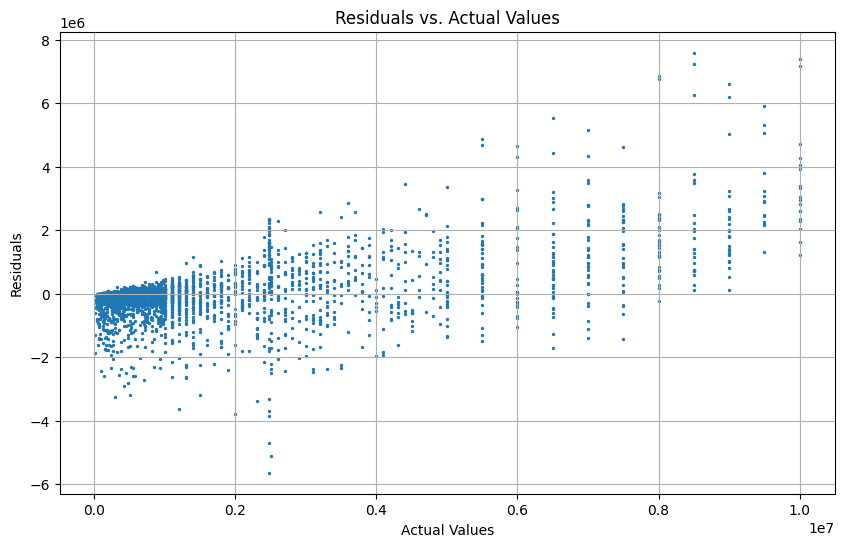

In [67]:
def plot_residuals(y_test, y_pred):
    residuals = y_test - y_pred

    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, residuals, s=2)
    plt.title('Residuals vs. Actual Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.show()

    # plt.figure(figsize=(10, 6))
    # sns.histplot(residuals, kde=True)
    # plt.title('Distribution of Residuals')
    # plt.xlabel('Residuals')
    # plt.ylabel('Frequency')
    # plt.show()

plot_residuals(y_test, y_pred)

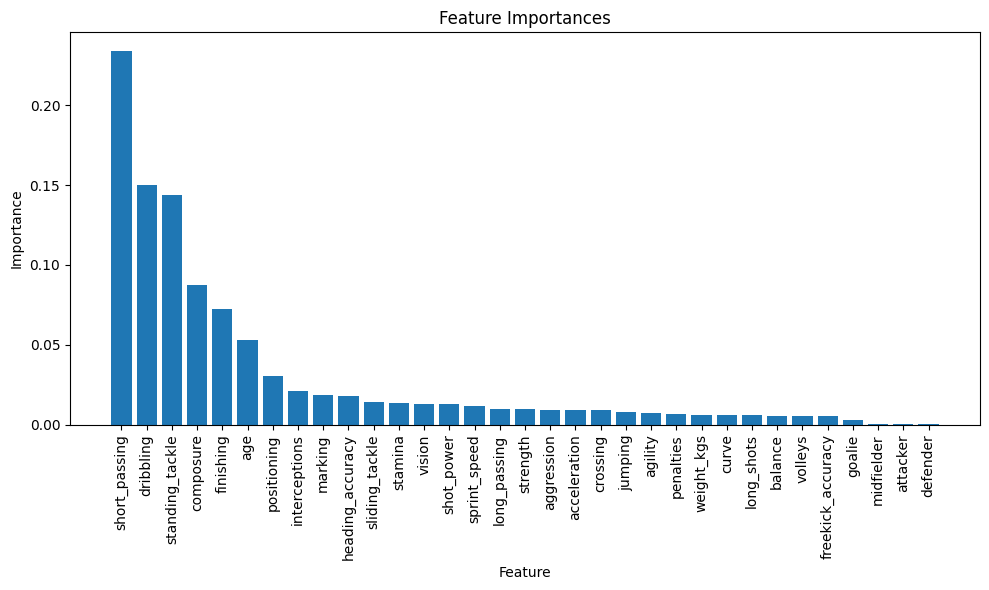

            Feature  Importance
5     short_passing    0.234038
7         dribbling    0.150221
27  standing_tackle    0.144112
25        composure    0.087695
3         finishing    0.072484
0               age    0.052686
22      positioning    0.030282
21    interceptions    0.021348
              Feature  Importance
19         long_shots    0.005804
14            balance    0.005560
6             volleys    0.005524
9   freekick_accuracy    0.005091
32             goalie    0.003171
30         midfielder    0.000468
29           attacker    0.000285
31           defender    0.000246


In [68]:
def plot_feature_importances(model, X_train):
    feature_importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.xticks(rotation=90)
    plt.title('Feature Importances')
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()

    print(feature_importance_df.head(8))
    print(feature_importance_df.tail(8))

def get_important_features(model, X_train, threshold):
    feature_importances = model.feature_importances_
    important_features = X_train.columns[feature_importances > threshold]
    return important_features

def make_model_with_important_features(X, y, important_features):
    X_important = X[important_features]
    model, X_train, X_test, y_train, y_test, y_pred = train_model(X_important, y)
    return model, X_train, X_test, y_train, y_test, y_pred

plot_feature_importances(model, X_train)

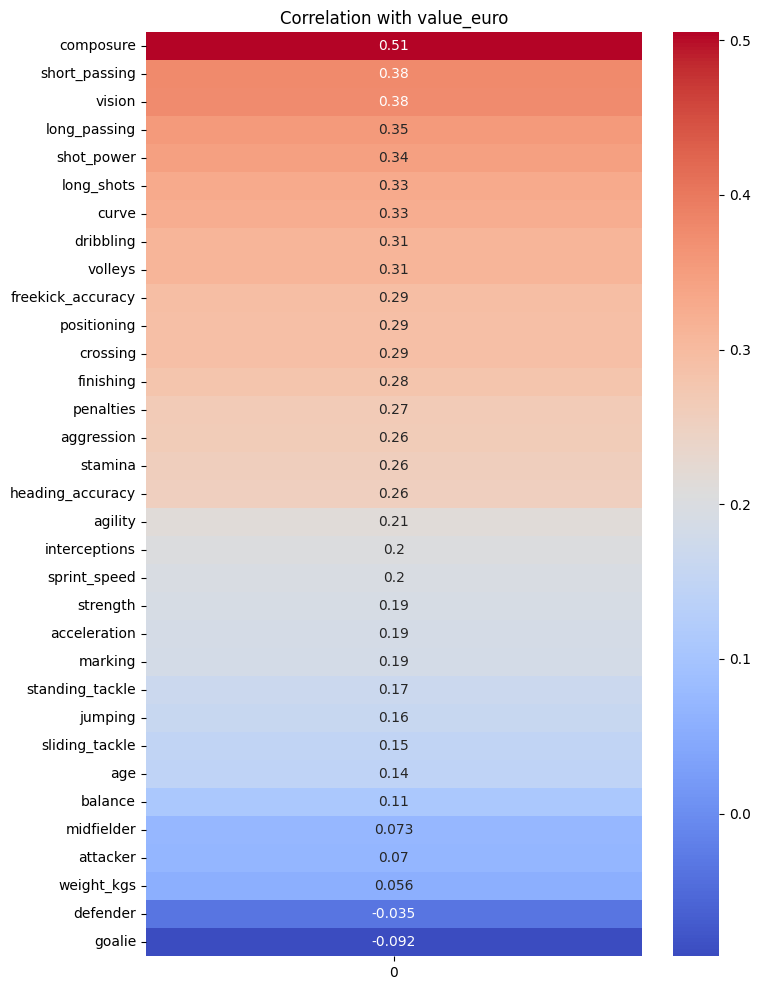

In [69]:
def correlation_matrix(X, y):
    correlation_matrix = X.corrwith(y, numeric_only=True).sort_values(ascending=False)

    plt.figure(figsize=(8, 12))
    sns.heatmap(correlation_matrix.to_frame(), annot=True, cmap='coolwarm')
    plt.title('Correlation with value_euro')
    plt.show()

correlation_matrix(X, y)

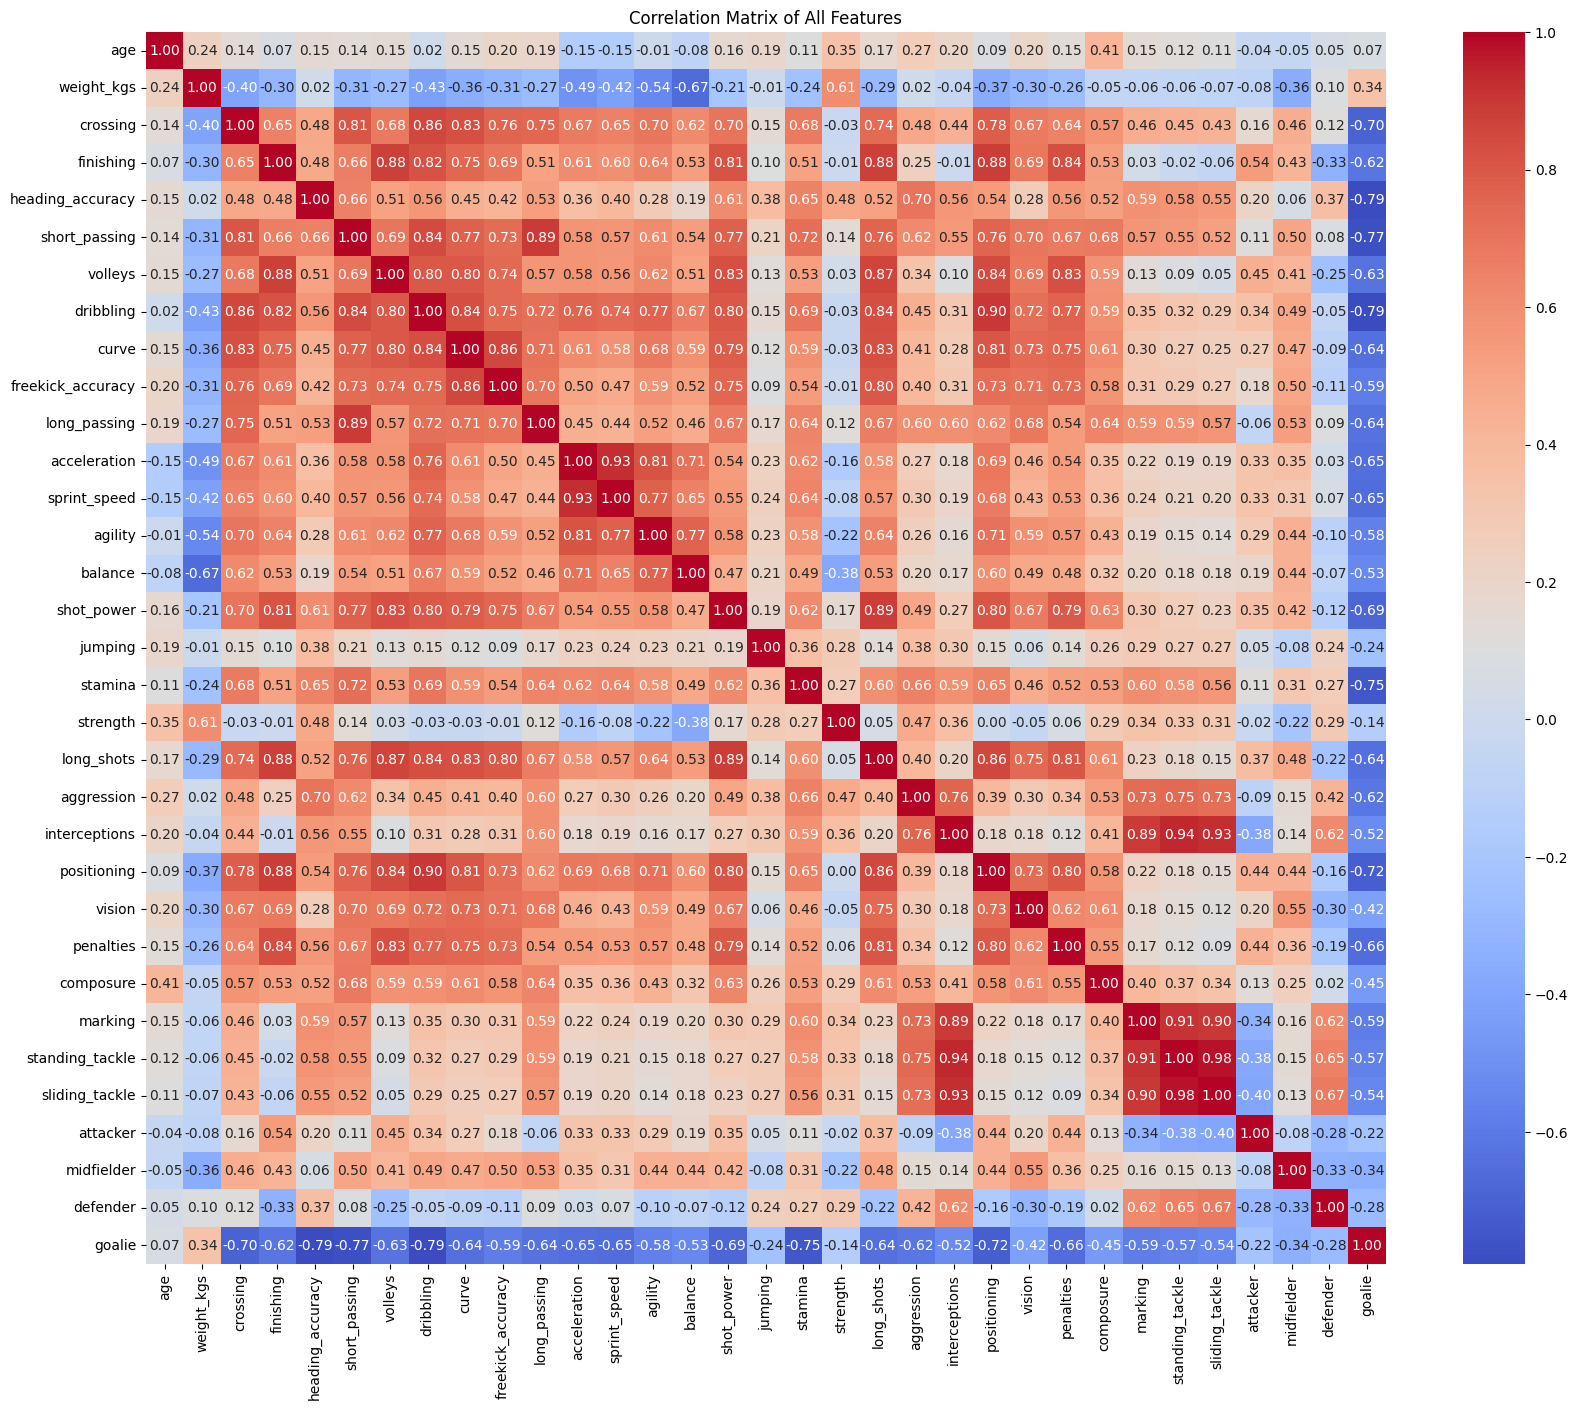

In [70]:
def correlation_matrix_x(X):
    corr = X.corr()
    plt.figure(figsize=(20, 16))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix of All Features')
    plt.show()
correlation_matrix_x(X)

Height is strongly correlated with weight, and should be used only for goalkeepers
Height - drop (except goalkeepers), weight-stay

Insignificant features:
1. Prefferred foot
2. Body type
3. Tier_encoded
4. weak_foot

Too significant features:
1. Reactions
2. Potential

In [71]:
X_attackers_only = X.copy()
X_attackers = X_attackers_only[~X_attackers_only['attacker'].isna()]
X_attackers = X_attackers[X_attackers['attacker'] == 1]
X_attackers.drop(columns=['attacker', 'midfielder', 'defender', 'goalie'], inplace=True)

y_attackers = y[X_attackers_only.index]
X_attackers = X_attackers[X_attackers.index.isin(y_attackers.index)]
y_attackers = y_attackers[y_attackers.index.isin(X_attackers.index)]



X_midfielders_only = X.copy()
X_midfielders = X_midfielders_only[~X_midfielders_only['midfielder'].isna()]
X_midfielders = X_midfielders[X_midfielders['midfielder'] == 1]
X_midfielders.drop(columns=['attacker', 'midfielder', 'defender', 'goalie'], inplace=True)

y_midfielders = y[X_midfielders_only.index]
X_midfielders = X_midfielders[X_midfielders.index.isin(y_midfielders.index)]
y_midfielders = y_midfielders[y_midfielders.index.isin(X_midfielders.index)]


X_defenders_only = X.copy()
X_defenders = X_defenders_only[~X_defenders_only['defender'].isna()]
X_defenders = X_defenders[X_defenders['defender'] == 1]
X_defenders.drop(columns=['attacker', 'midfielder', 'defender', 'goalie'], inplace=True)

y_defenders = y[X_defenders_only.index]
X_defenders = X_defenders[X_defenders.index.isin(y_defenders.index)]
y_defenders = y_defenders[y_defenders.index.isin(X_defenders.index)]


X_goalies_only = X.copy()
X_goalies = X_goalies_only[~X_goalies_only['goalie'].isna()]
X_goalies = X_goalies[X_goalies['goalie'] == 1]
X_goalies.drop(columns=['attacker', 'midfielder', 'defender', 'goalie'], inplace=True)

y_goalies = y[X_goalies_only.index]
X_goalies = X_goalies[X_goalies.index.isin(y_goalies.index)]
y_goalies = y_goalies[y_goalies.index.isin(X_goalies.index)]


In [72]:
#confirm shapes
print(X_attackers.shape)
print(y_attackers.shape)

print(X_midfielders.shape)
print(y_midfielders.shape)

print(X_defenders.shape)
print(y_defenders.shape)

print(X_goalies.shape)
print(y_goalies.shape)

(4556, 29)
(4556,)
(8026, 29)
(8026,)
(6348, 29)
(6348,)
(2003, 29)
(2003,)


In [73]:
model, X_train, X_test, y_train, y_test, y_pred = train_model(X_attackers, y_attackers)

Mean Squared Error: 796826658167.3448
R^2 Score: 0.8364112959418578
1761195.2088432652


In [74]:
def plot_value_vs_feature_log(feature, X_test, y_test, y_pred):
    plt.figure(figsize=(10, 6))
    sns.regplot(x=X_test[feature], y=y_test, scatter_kws={'alpha':0.5}, label='Actual', marker='o', color='blue')
    sns.regplot(x=X_test[feature], y=y_pred, scatter=False, label='Predicted', color='red')
    plt.title(f'{feature} vs Value (Euro)')
    plt.yscale('log')  # Using logarithmic scale for y-axis
    plt.xlabel(feature)
    plt.ylabel('Value (Euro)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [75]:
def plot_value_vs_feature(feature, X_test, y_test, y_pred):
    plt.figure(figsize=(10, 6))
    sns.regplot(x=X_test[feature], y=y_test, scatter_kws={'alpha':0.5}, label='Actual', marker='o', color='blue')
    sns.regplot(x=X_test[feature], y=y_pred, scatter=False, label='Predicted', color='red')
    plt.title(f'{feature} vs Value (Euro)')
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
    plt.gca().yaxis.get_offset_text().set_position((0,1.1))
    plt.gca().yaxis.get_offset_text().set_fontsize(12)
    plt.xlabel(feature)
    plt.ylabel('Value (Euro)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [76]:
X_attackers.drop(columns=['weight_kgs'], inplace=True)

In [77]:
expo_features = ['finishing', 'short_passing', 'dribbling', 'shot_power','positioning']

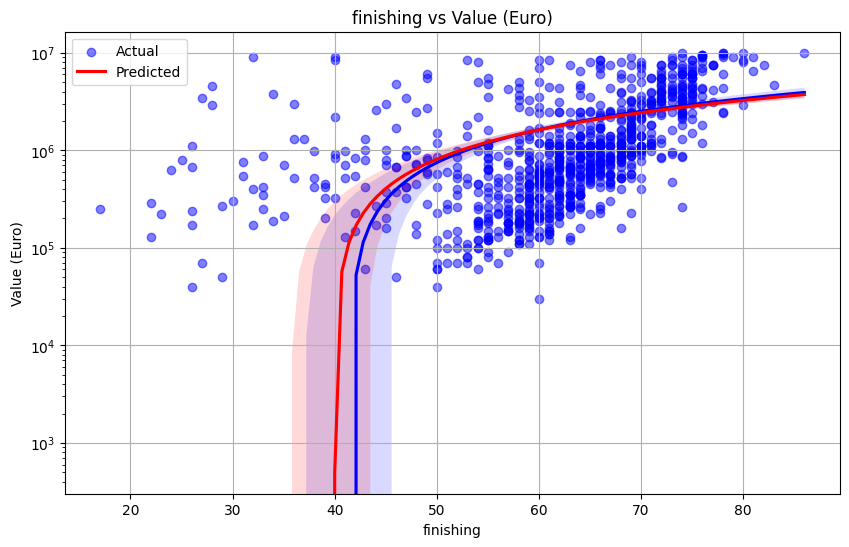

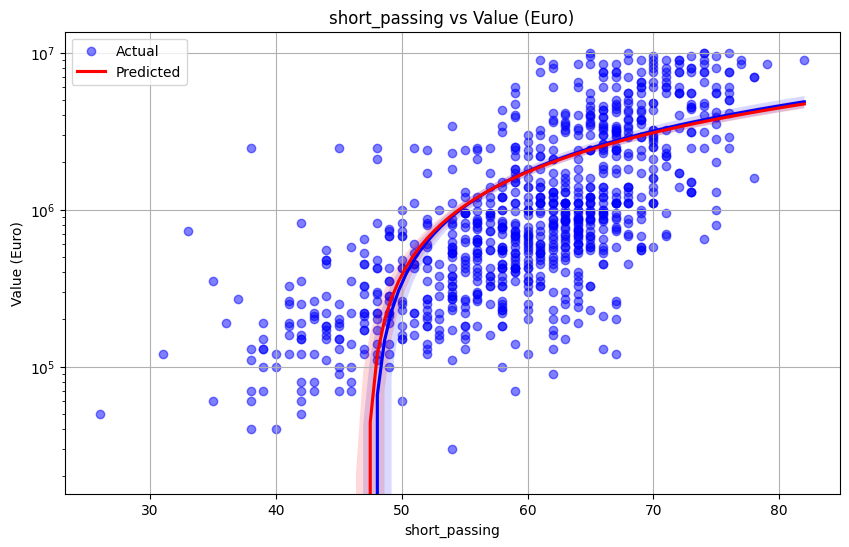

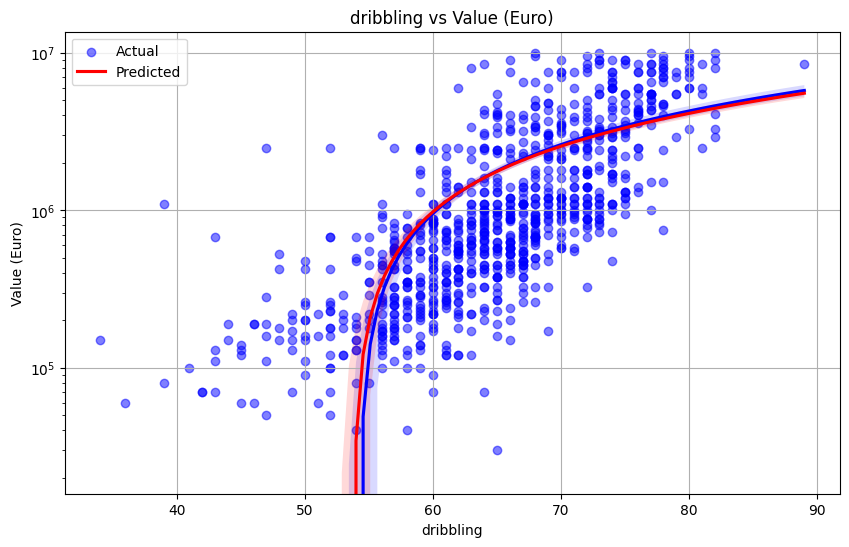

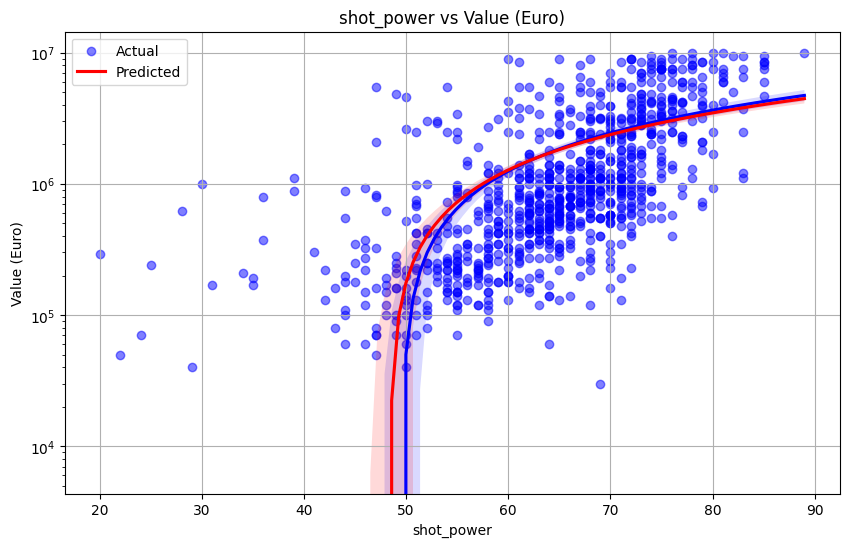

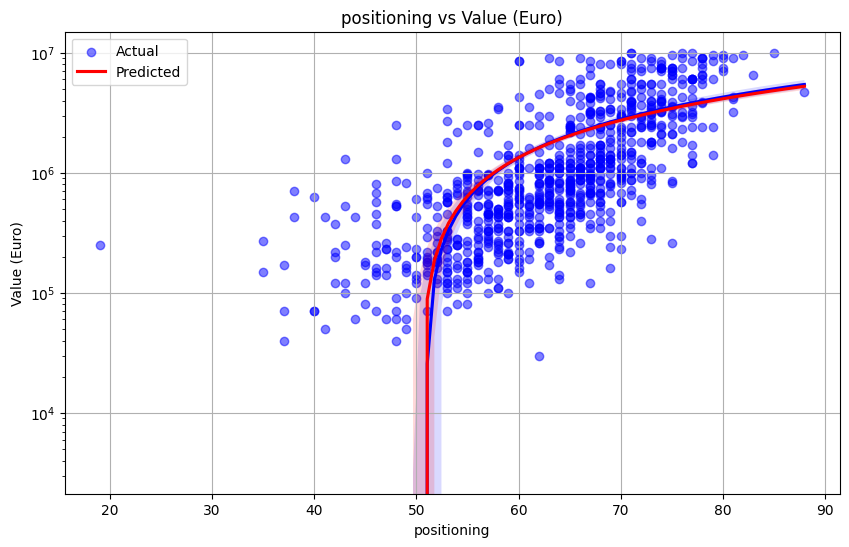

In [78]:
for feature in expo_features:
    plot_value_vs_feature_log(feature, X_test, y_test, y_pred)

Defenders - marking, sliding tackle, standing tackle, interceptions, aggression

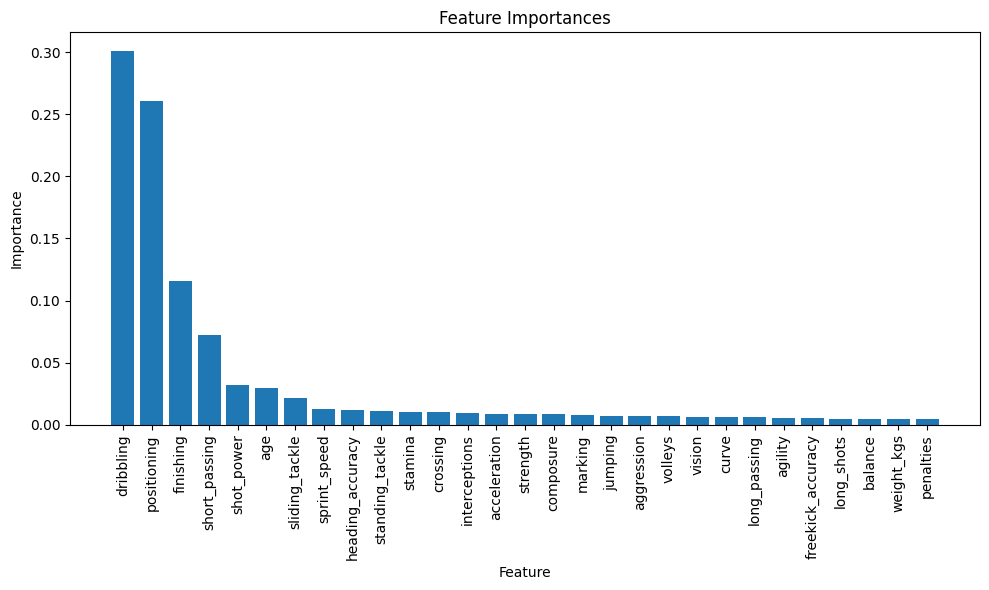

           Feature  Importance
7        dribbling    0.301084
22     positioning    0.261037
3        finishing    0.115762
5    short_passing    0.071929
15      shot_power    0.032165
0              age    0.029556
28  sliding_tackle    0.021449
12    sprint_speed    0.012608
              Feature  Importance
8               curve    0.006170
10       long_passing    0.006033
13            agility    0.005607
9   freekick_accuracy    0.005514
19         long_shots    0.004767
14            balance    0.004677
1          weight_kgs    0.004573
24          penalties    0.004236


In [79]:
#plot_residuals(y_test, y_pred)
plot_feature_importances(model, X_train)
#correlation_matrix(X_attackers, y)
#correlation_matrix_x(X_attackers)

We need to drop 'ball control' because it influences the regression too much.

In [ ]:
# X_attackers.loc[X_attackers['crossing'] > 85, 'crossing'] -= 1
# X_attackers.loc[X_attackers['heading_accuracy'] >= 88, 'heading_accuracy'] -= 2
# X_attackers.loc[X_attackers['volleys'] > 86, 'volleys'] -= 1
# X_attackers.loc[X_attackers['freekick_accuracy'] > 87, 'freekick_accuracy'] -= 1
# X_attackers.loc[X_attackers['long_passing'] > 80, 'long_passing'] -= 5
# X_attackers.loc[X_attackers['acceleration'] > 96, 'acceleration'] -= 1
# X_attackers.loc[X_attackers['sprint_speed'] > 95, 'sprint_speed'] -= 1
# X_attackers.loc[X_attackers['shot_power'] > 87, 'shot_power'] -= 2
# X_attackers.loc[X_attackers['long_shots'] > 84, 'long_shots'] -= 1
# X_attackers.loc[X_attackers['acceleration'] > 93, 'acceleration'] -= 2
# X_attackers.loc[X_attackers['long_shots'] > 84, 'long_shots'] -= 1
#X_attackers.loc[X_attackers['vision'] > 84, 'vision'] -= 1

In [98]:
model, X_train, X_test, y_train, y_test, y_pred = train_model(X_attackers, y_attackers)

Mean Squared Error: 789515393904.3124
R^2 Score: 0.8379123002488258
1761195.2088432652


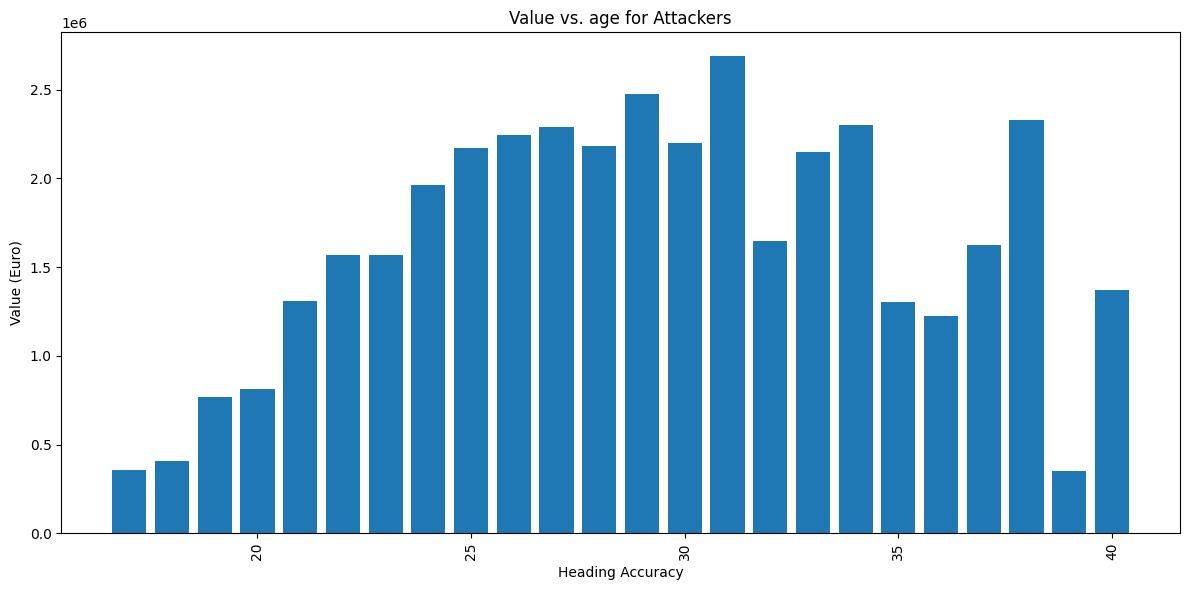

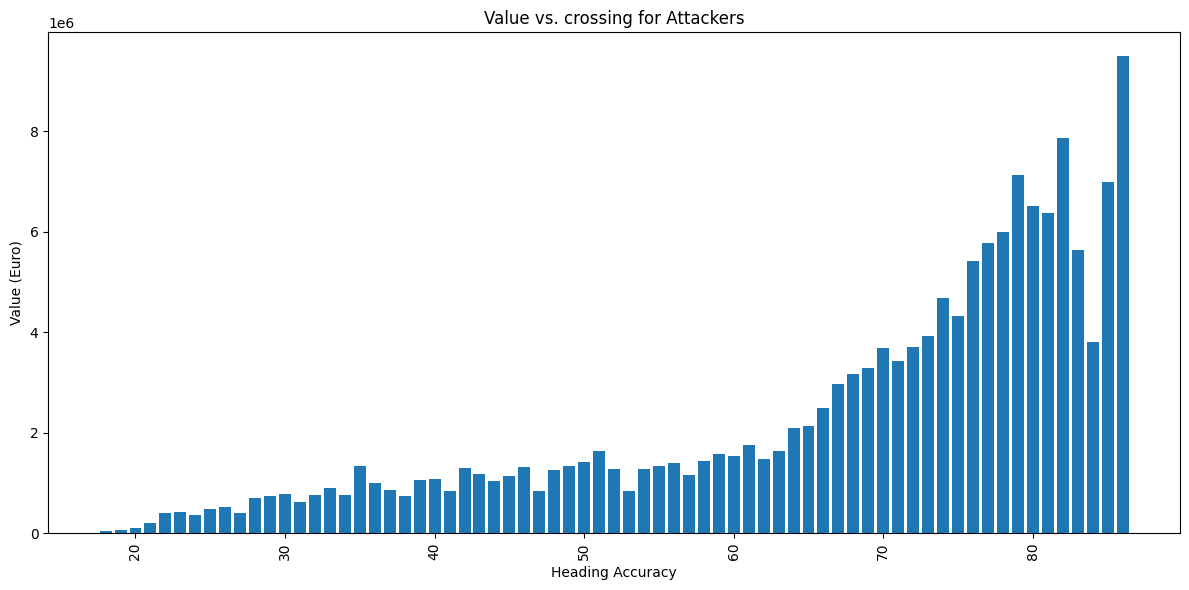

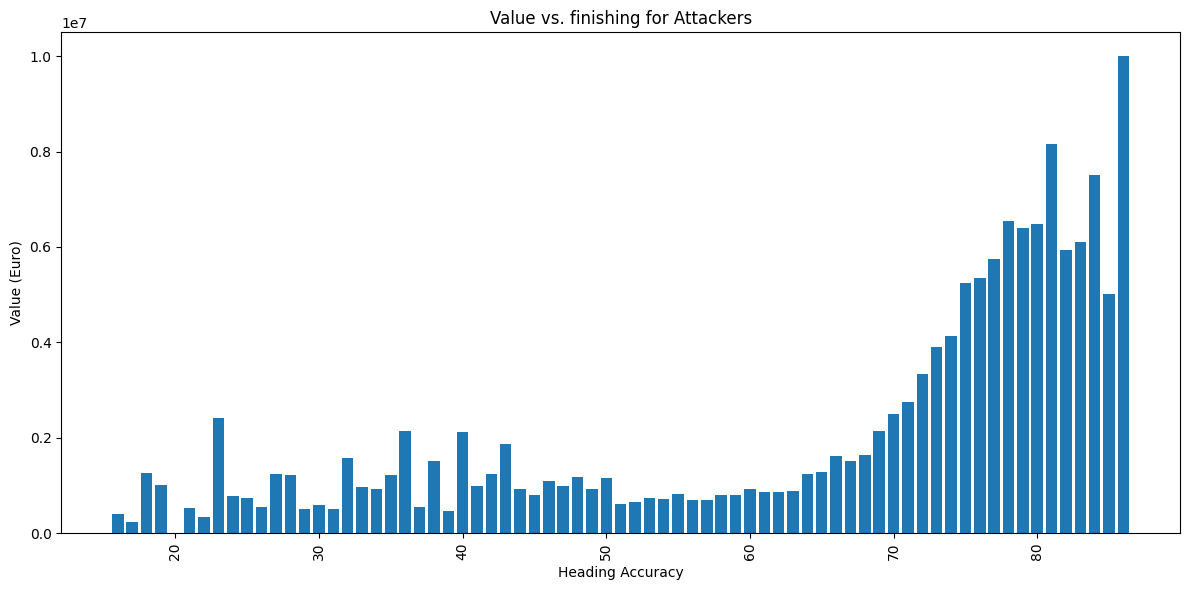

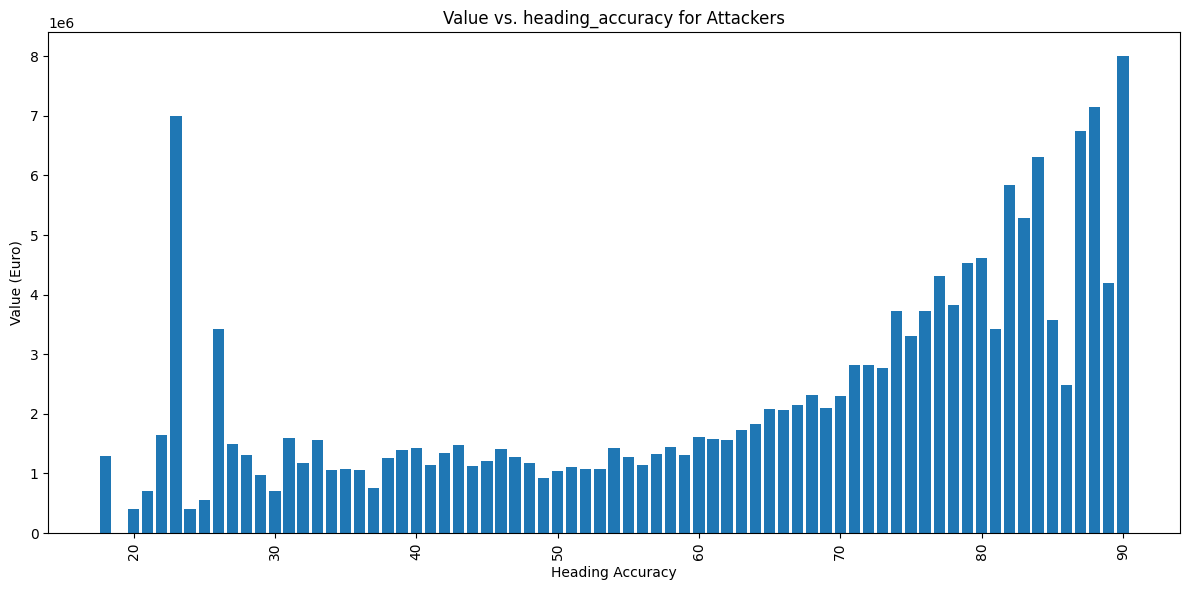

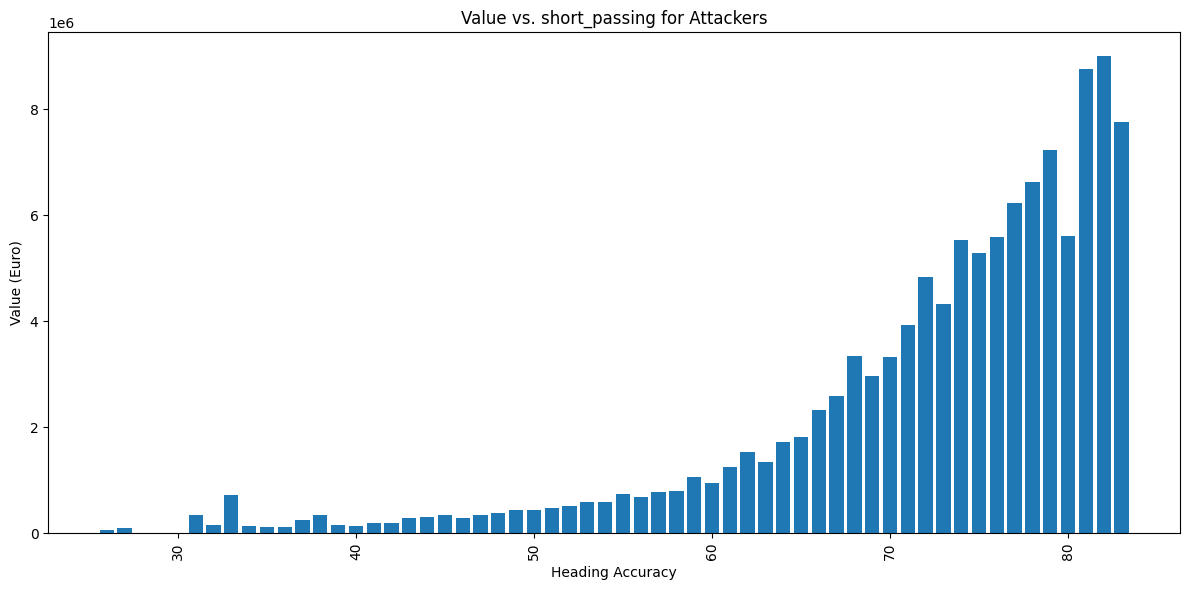

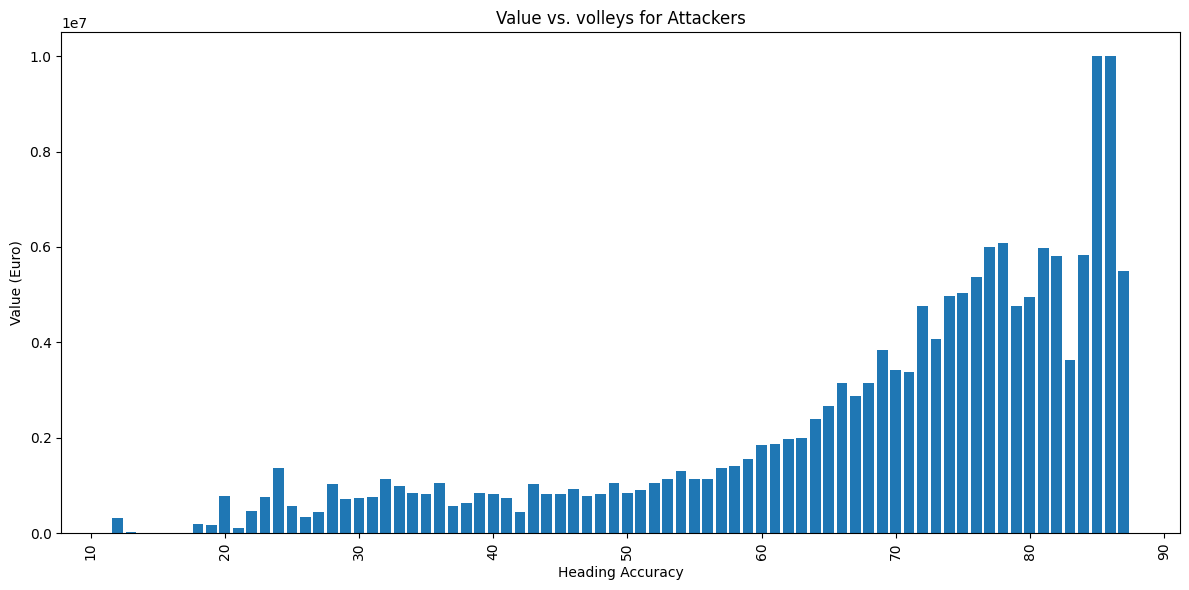

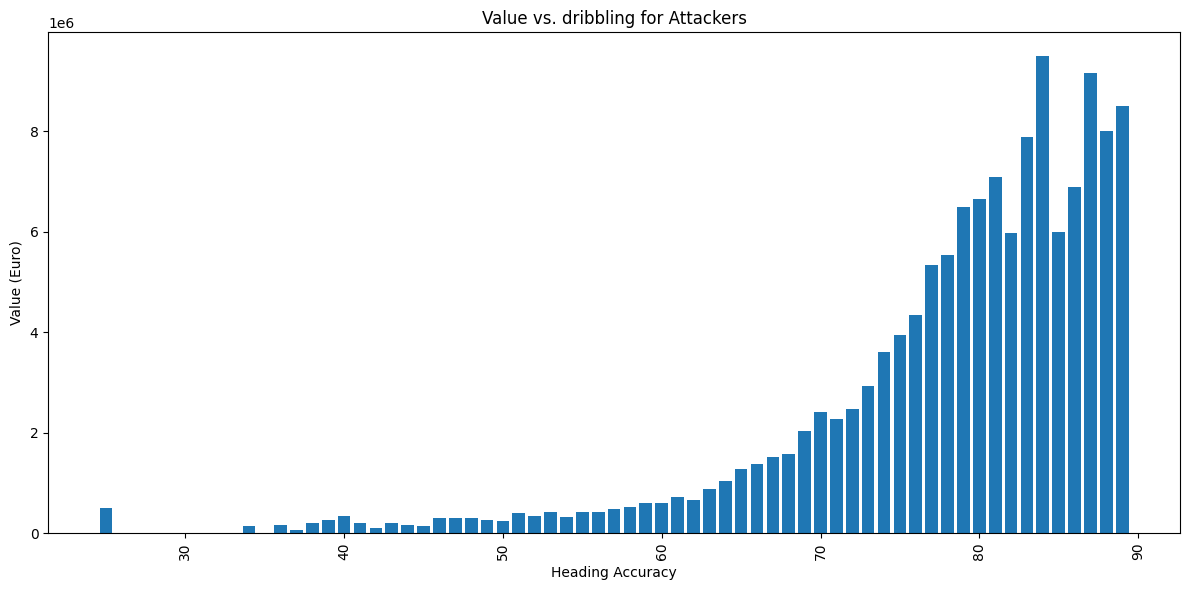

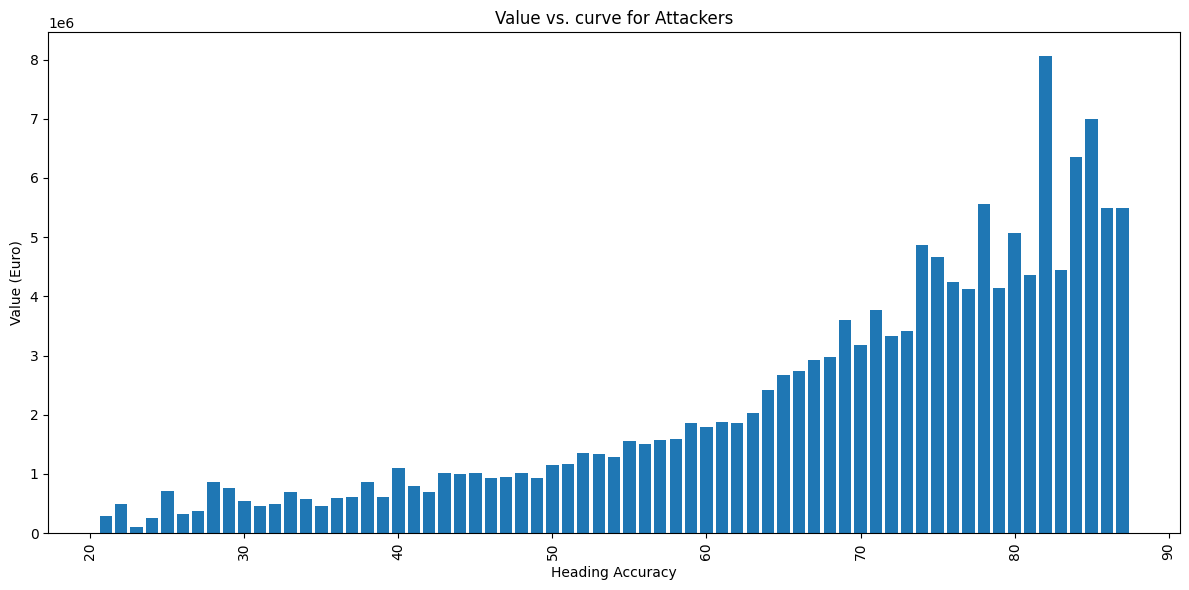

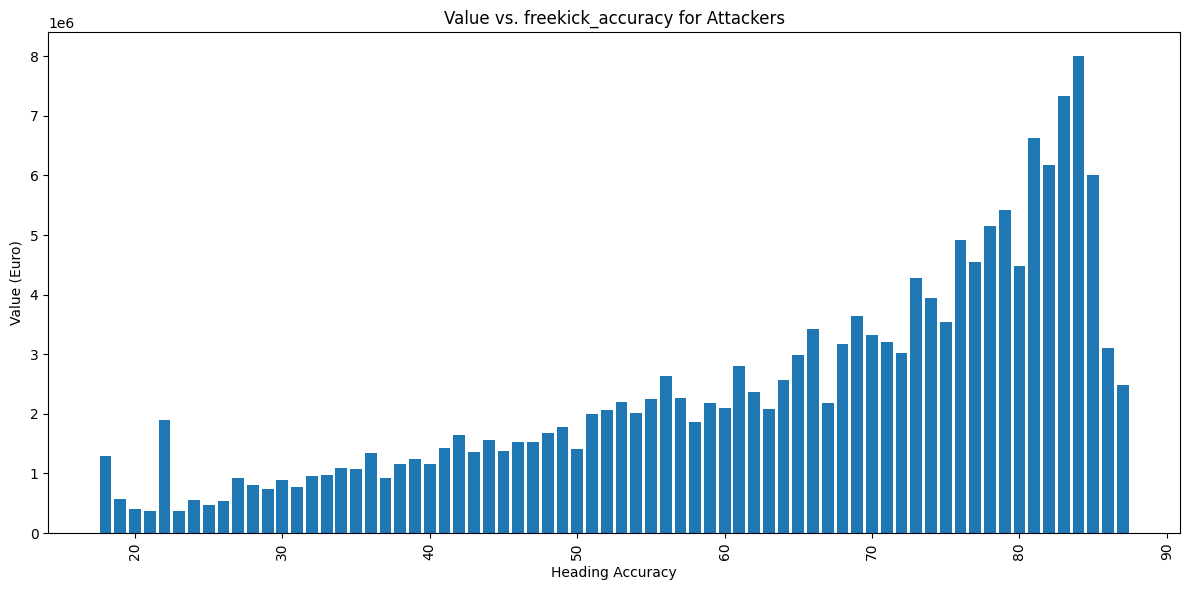

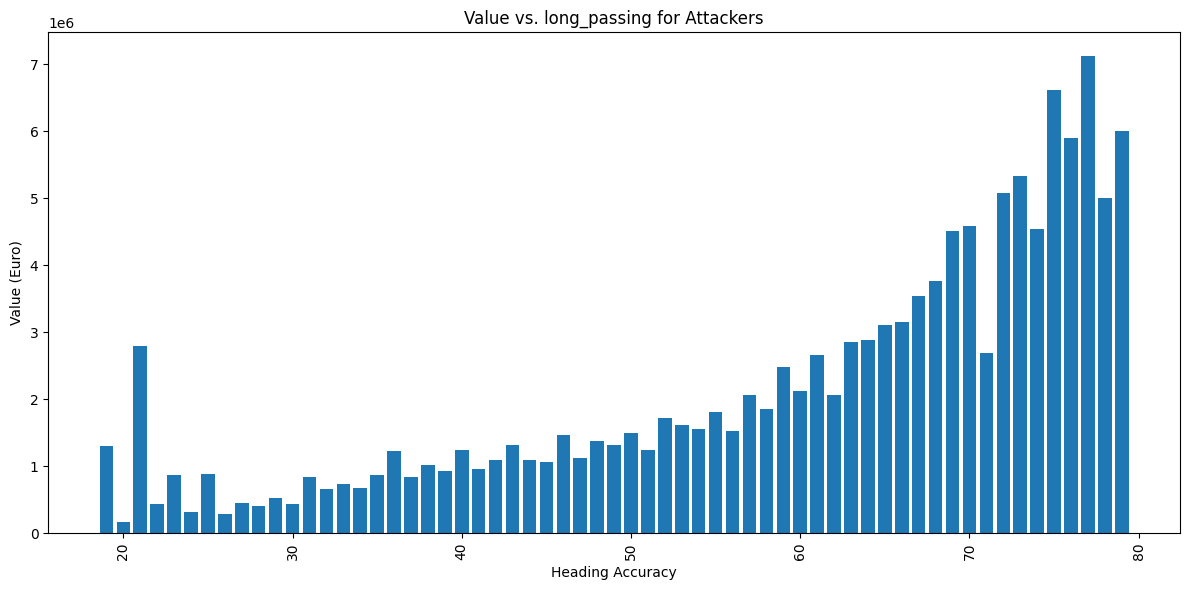

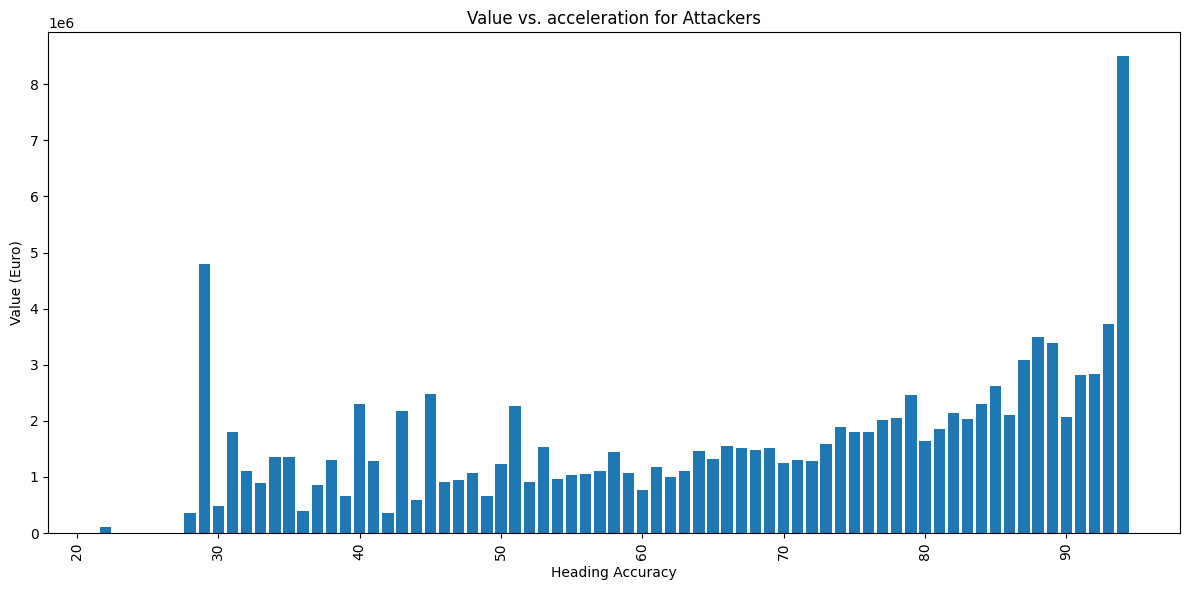

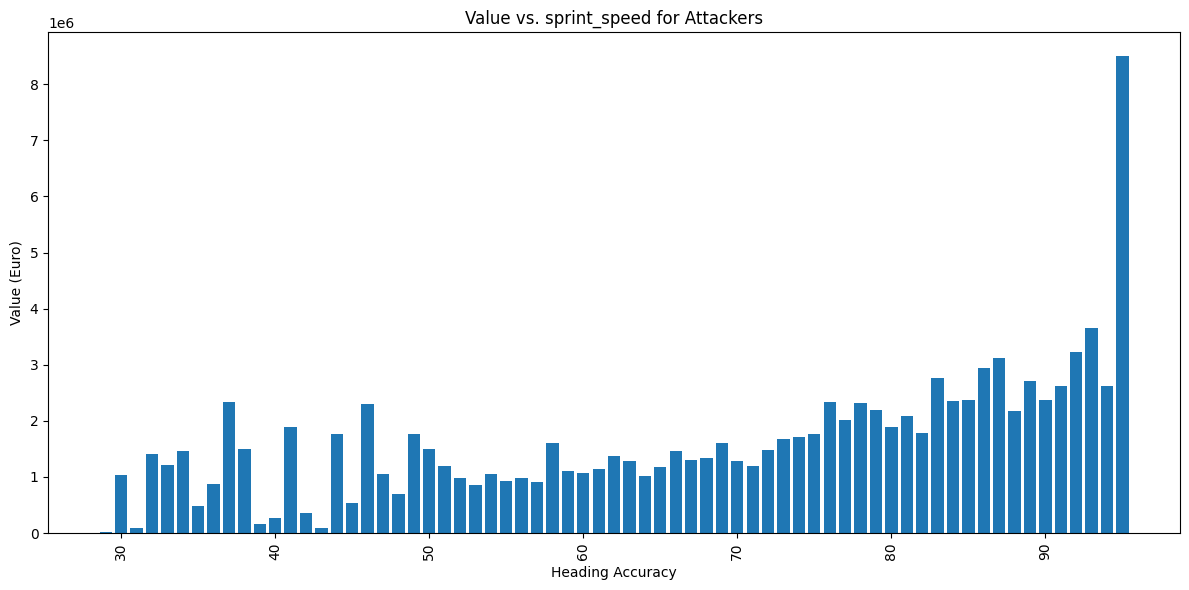

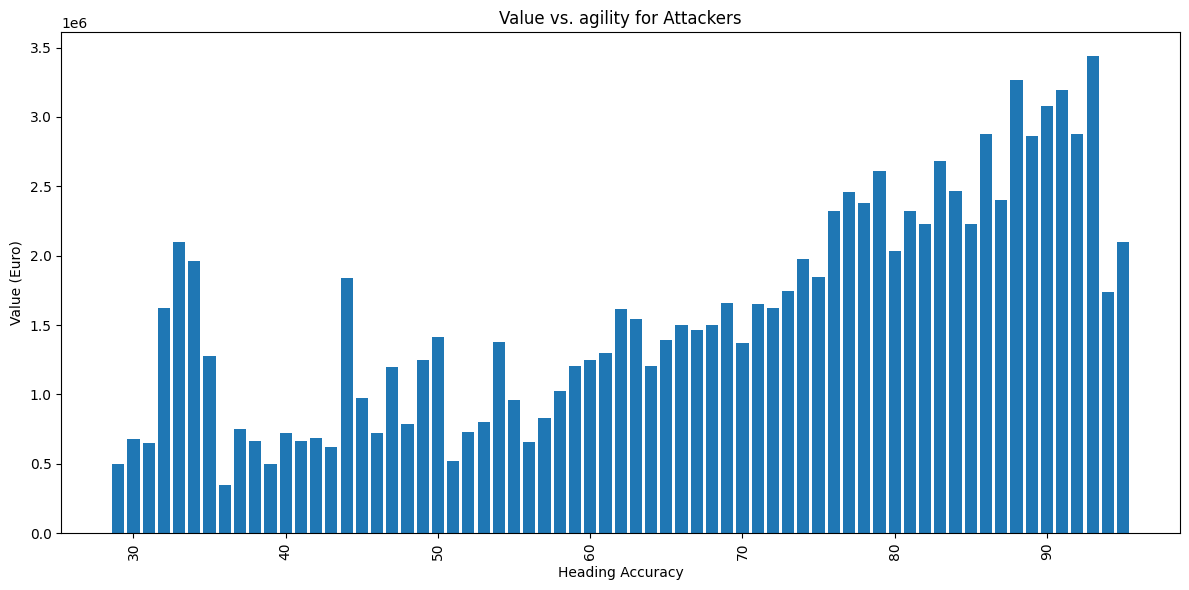

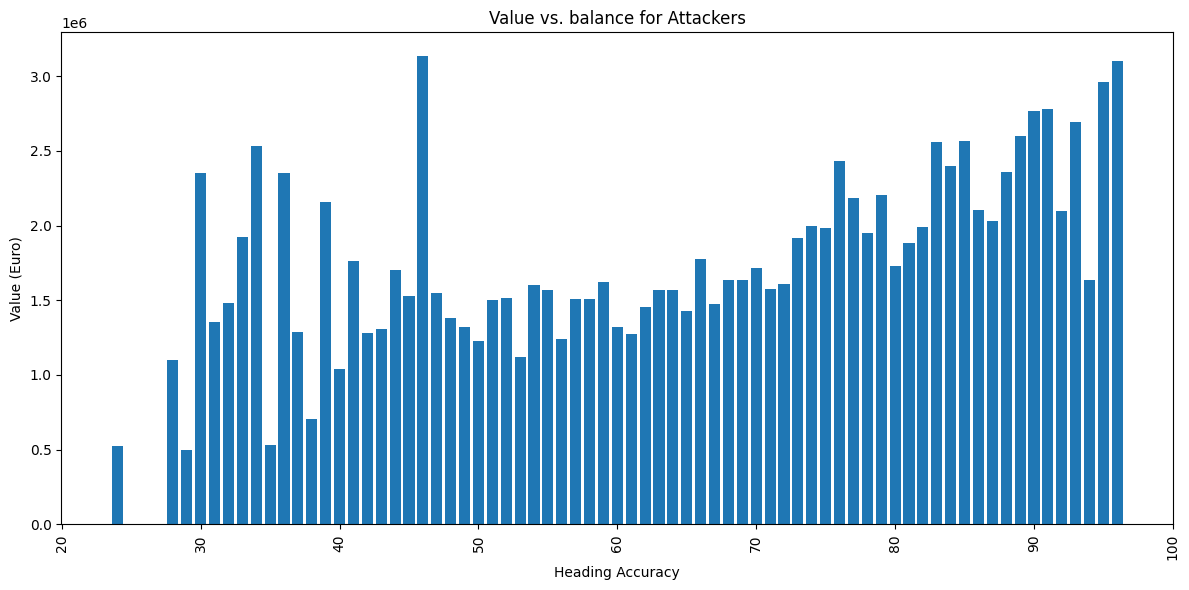

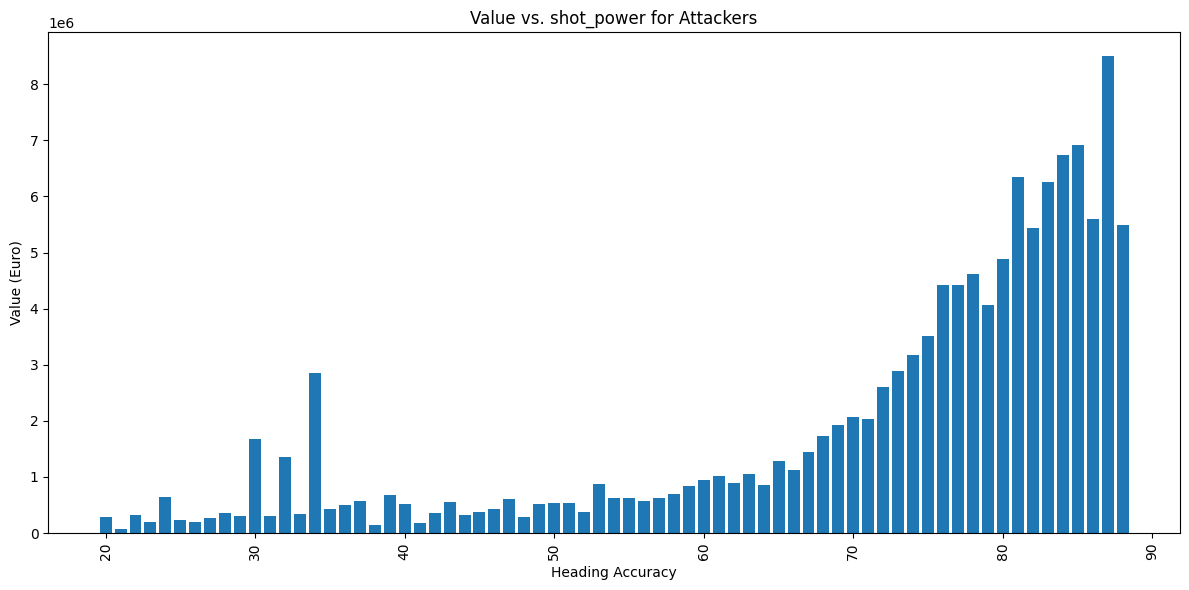

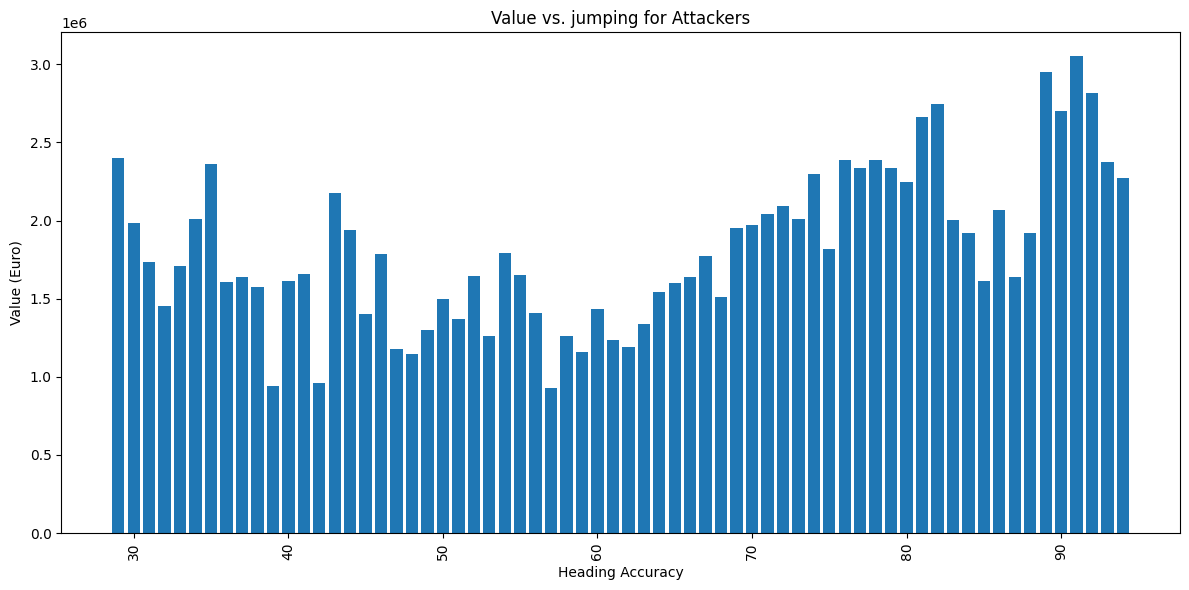

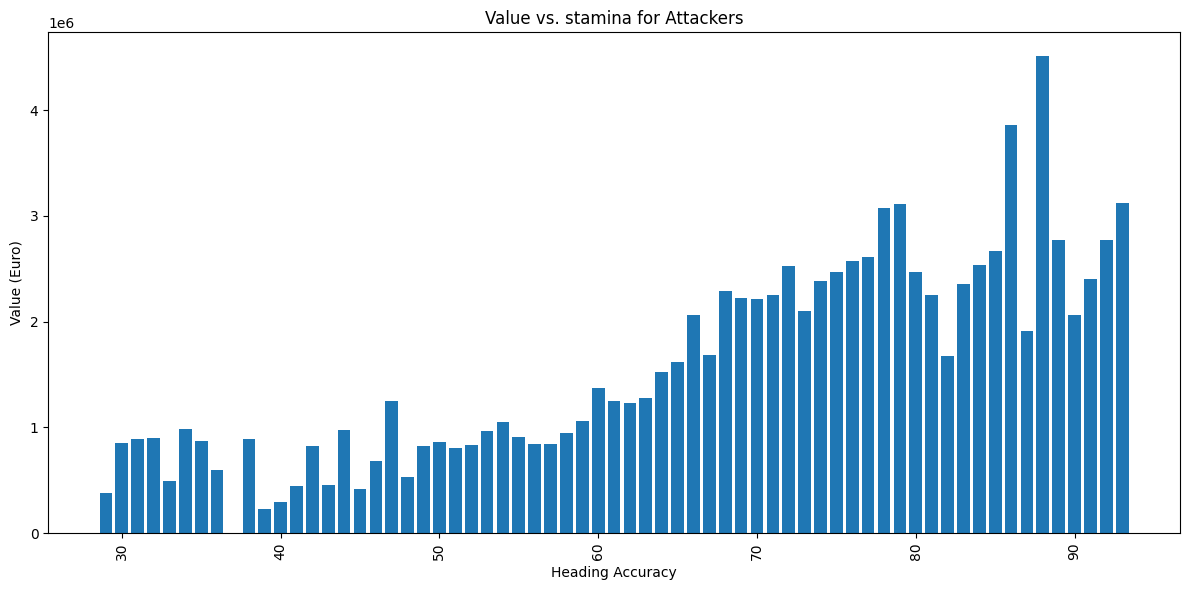

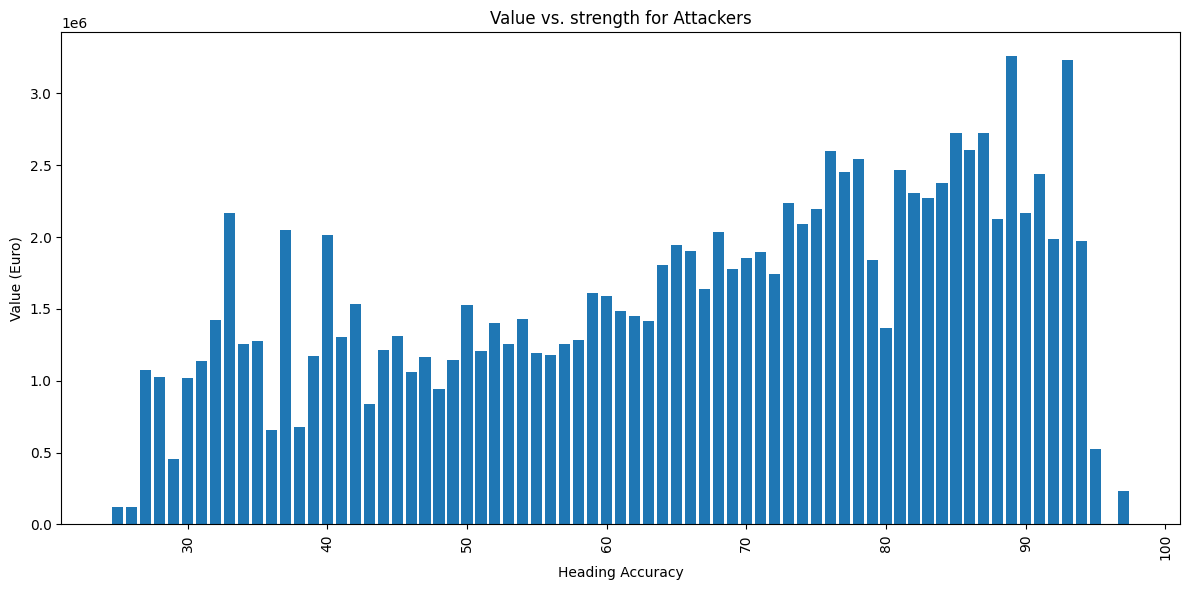

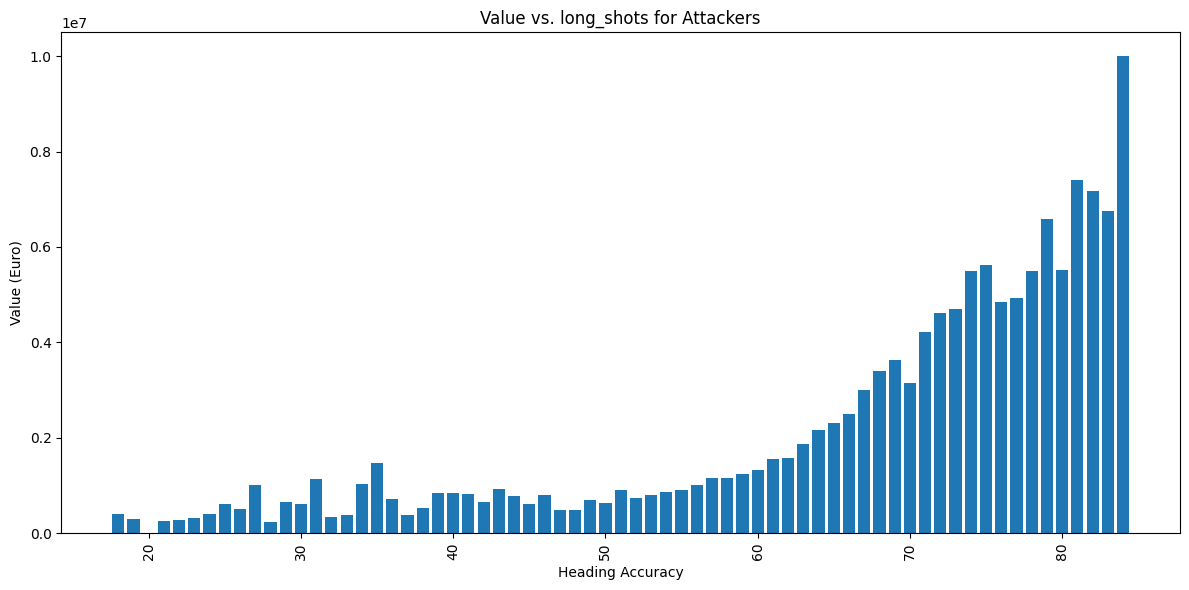

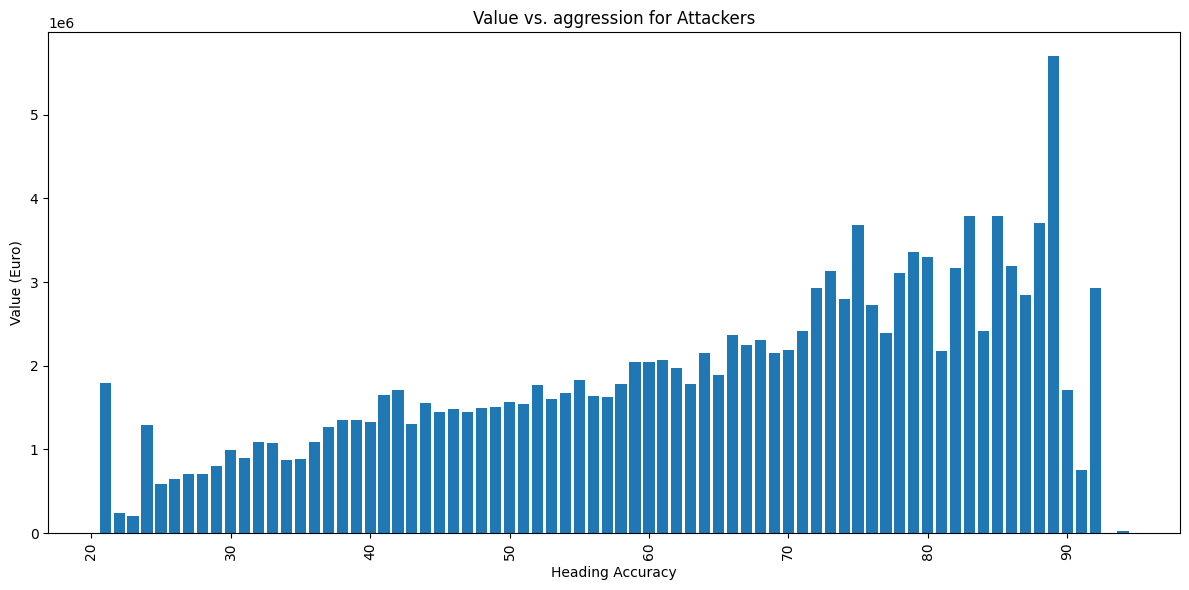

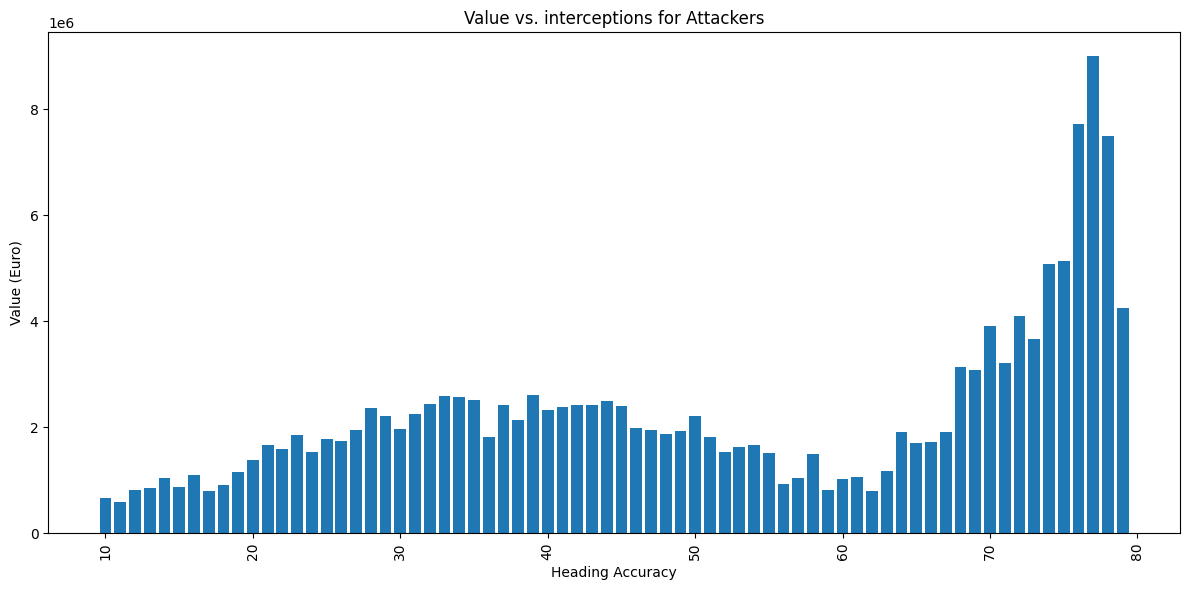

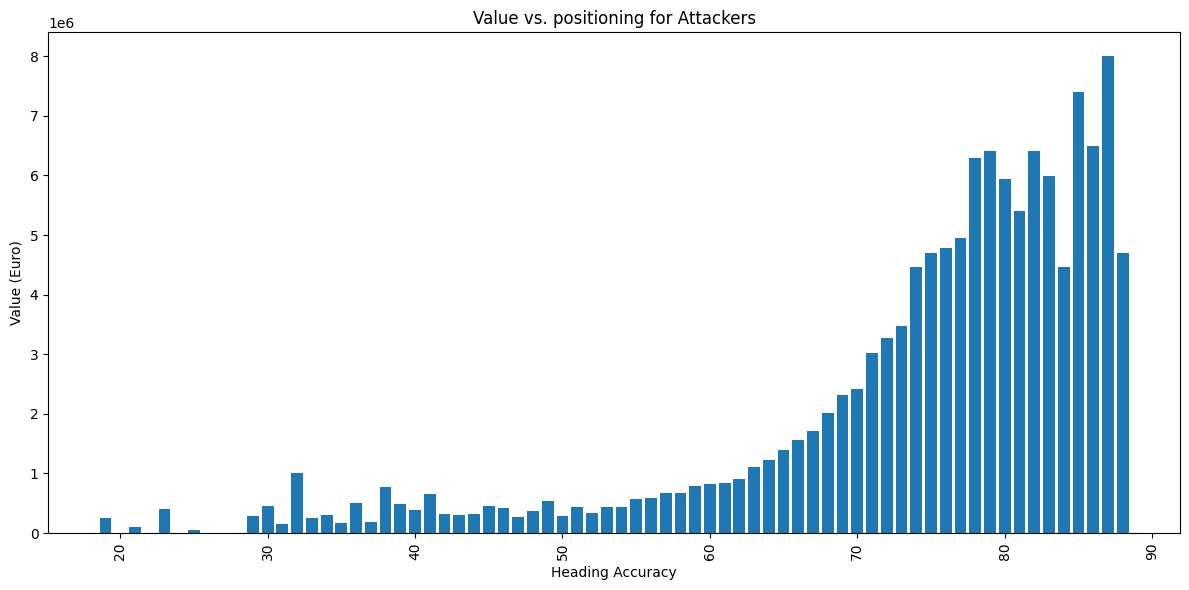

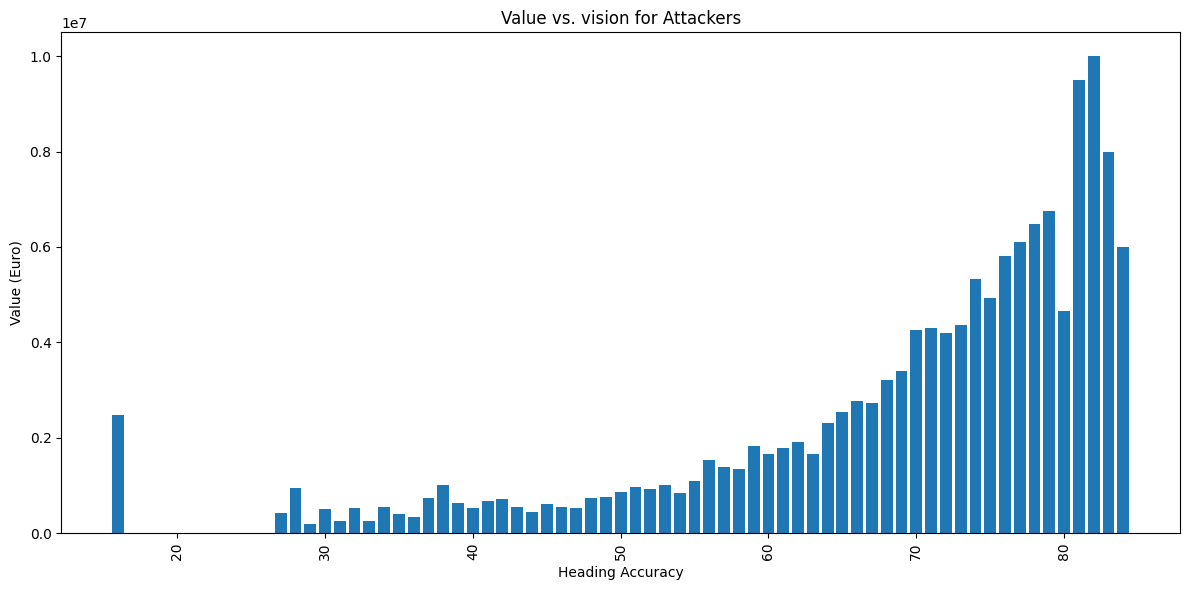

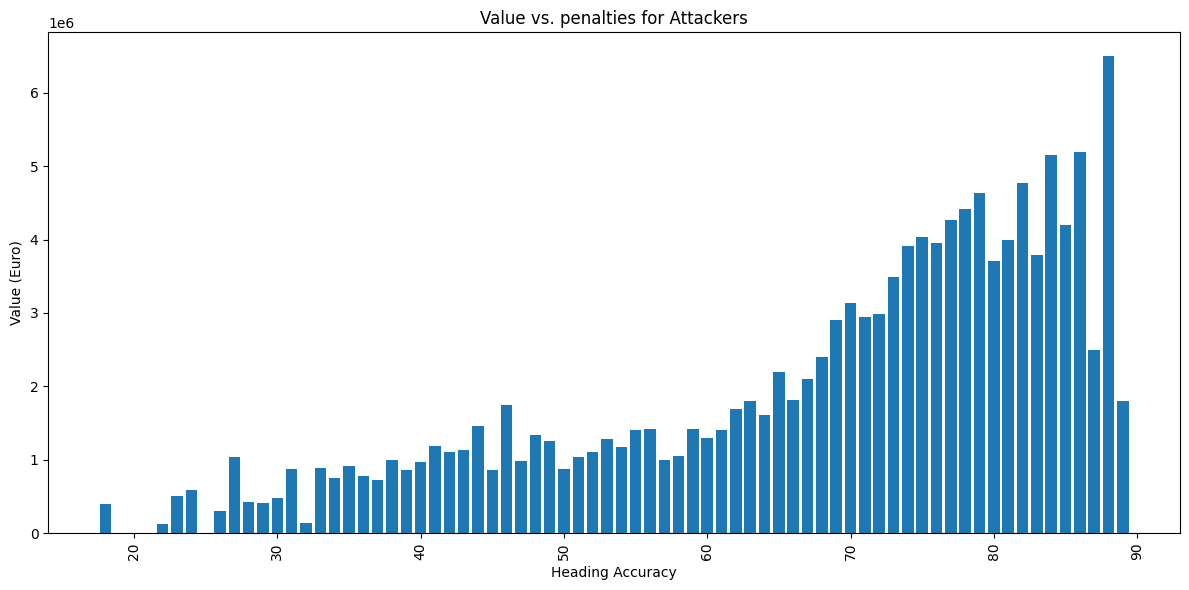

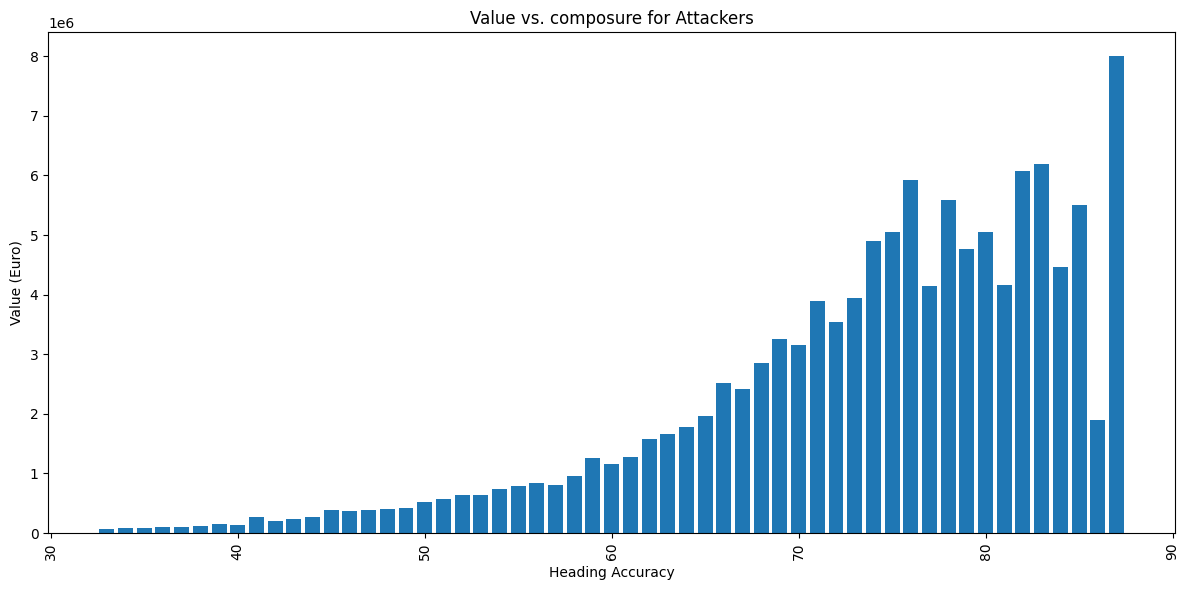

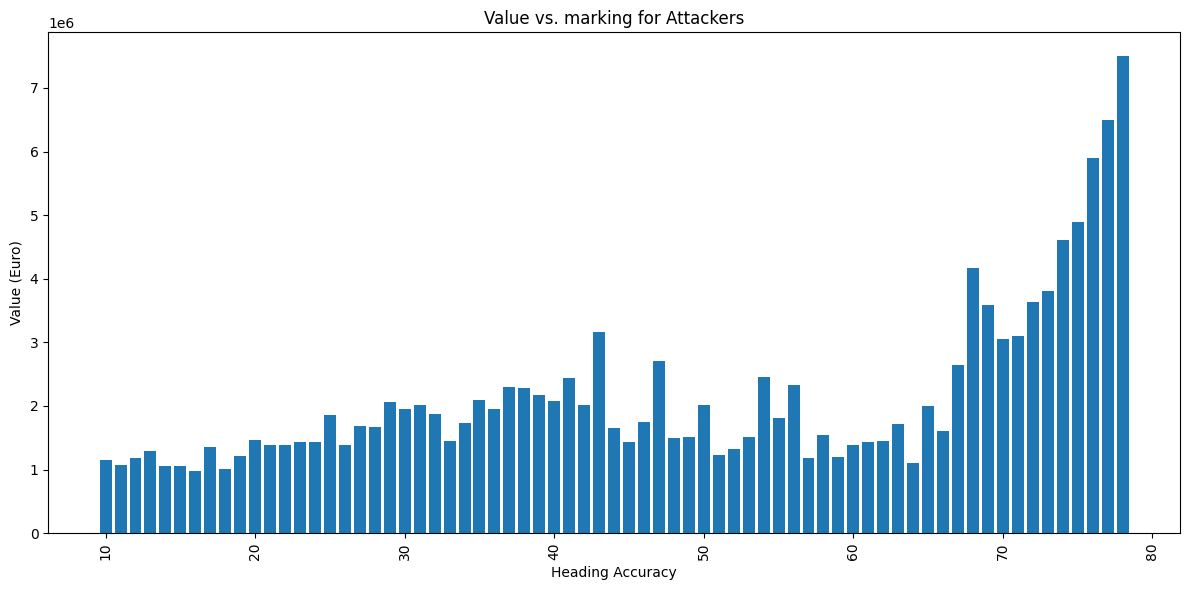

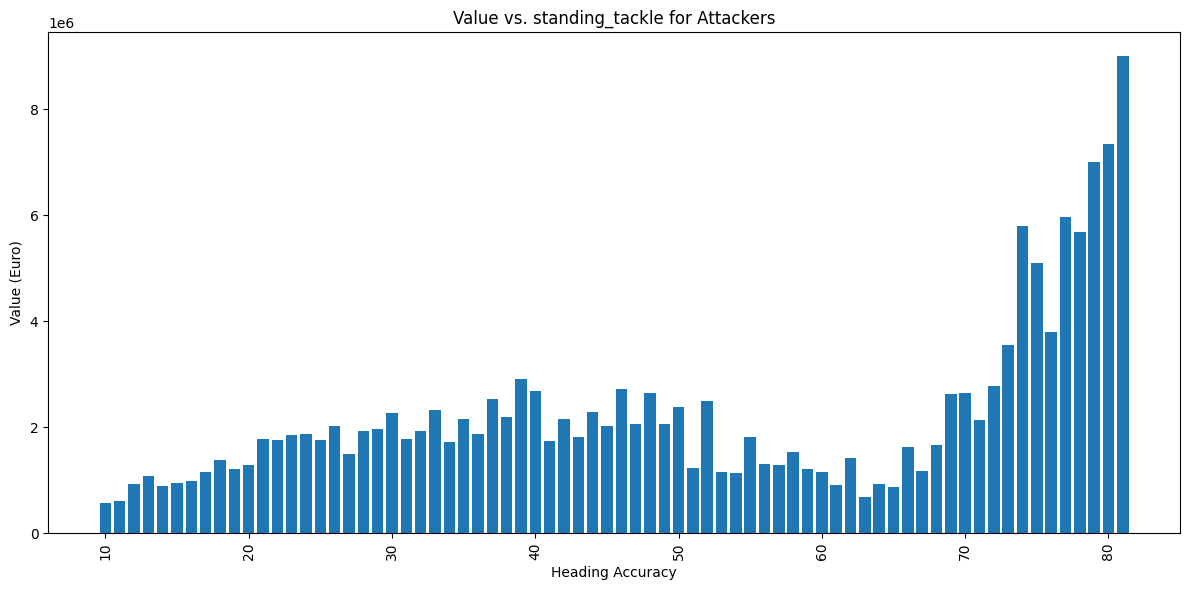

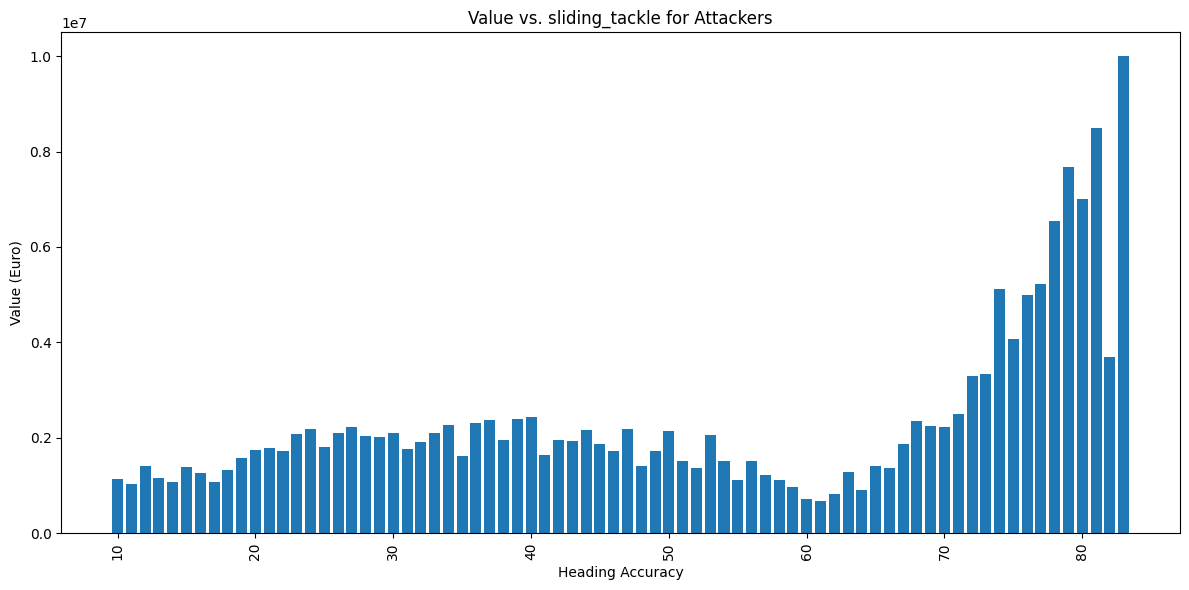

In [97]:
def barchart_by_feature(X_attackers, y_attackers, feature):
    plt.figure(figsize=(12, 6))
    average_value_by_heading = X_attackers.groupby(f'{feature}')[f'{feature}'].count()
    plt.bar(average_value_by_heading.index, y_attackers.groupby(X_attackers[f'{feature}']).mean())
    plt.xlabel('Heading Accuracy')
    plt.ylabel('Value (Euro)')
    plt.title("Value vs. " + str(feature) + " for Attackers")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

for feature in X_attackers.columns:
    barchart_by_feature(X_attackers, y_attackers, feature)

In [99]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate(y_test, y_pred):
    # Предсказания и реальные значения
    y_true = y_test
    y_predicted = y_pred

    mae = mean_absolute_error(y_true, y_predicted)
    mse = mean_squared_error(y_true, y_predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_predicted)

    print(f"MAE  = {mae:.2f}")
    print(f"MSE  = {mse:.2f}")
    print(f"RMSE = {rmse:.2f}")
    print(f"R²   = {r2:.4f}")

    print(f"Mean of y_test: {y_test.mean()}")
    print(f"Mean of y_pred: {y_pred.mean()}")

    print(f"Mean of y_test - y_pred: {y_test.mean() - y_pred.mean()}")
    

evaluate(y_test, y_pred)


MAE  = 501464.60
MSE  = 789515393904.31
RMSE = 888546.79
R²   = 0.8379
Mean of y_test: 1776821.6691051037
Mean of y_pred: 1754546.5981376688
Mean of y_test - y_pred: 22275.070967434905


Mean Squared Error: 1356180914549.1467
R^2 Score: 0.7215757329332623
1761195.2088432652


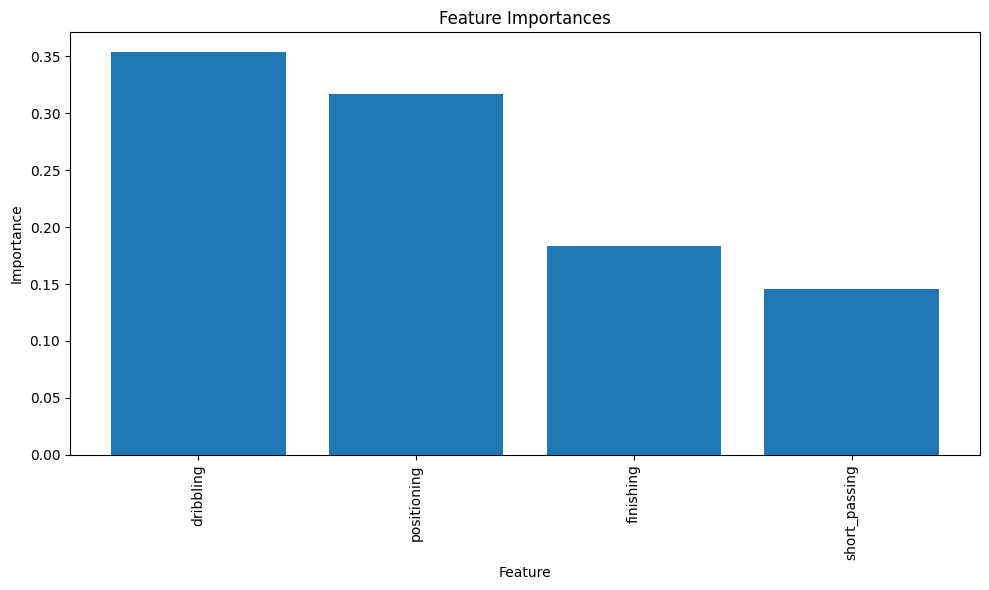

         Feature  Importance
2      dribbling    0.353419
3    positioning    0.317106
0      finishing    0.183828
1  short_passing    0.145647
         Feature  Importance
2      dribbling    0.353419
3    positioning    0.317106
0      finishing    0.183828
1  short_passing    0.145647


In [100]:
important_features = get_important_features(model, X_train, threshold=0.05)

model, X_train, X_test, y_train, y_test, y_pred = make_model_with_important_features(X_attackers, y_attackers, important_features)
plot_feature_importances(model, X_train)

In [83]:
model, X_train, X_test, y_train, y_test, y_pred = train_model(X_midfielders, y_midfielders)

Mean Squared Error: 650291535115.3987
R^2 Score: 0.8627617203414142
1682348.7143885598


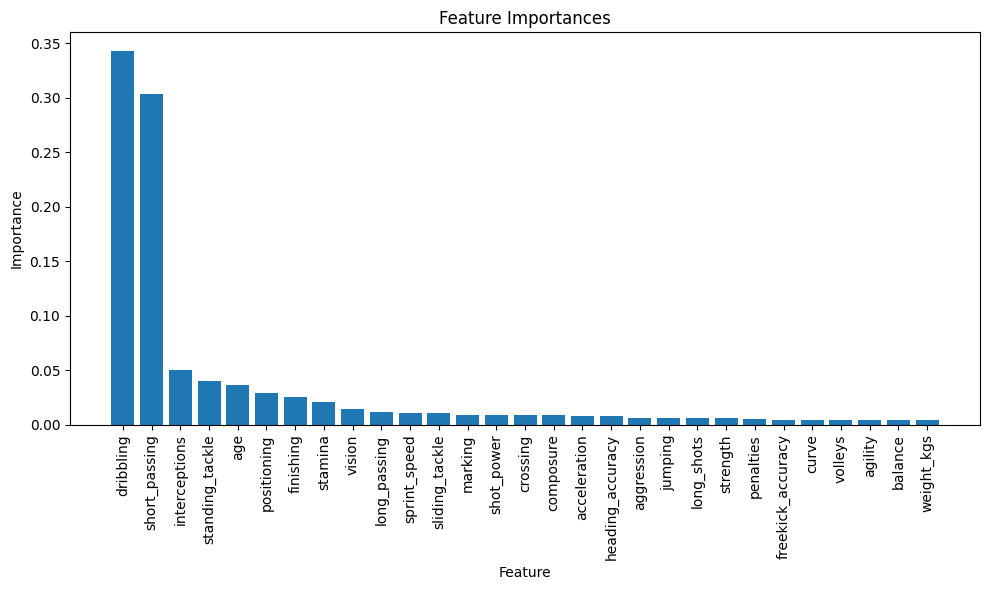

            Feature  Importance
7         dribbling    0.342840
5     short_passing    0.303199
21    interceptions    0.049921
27  standing_tackle    0.039852
0               age    0.036060
22      positioning    0.029129
3         finishing    0.024951
17          stamina    0.020822
              Feature  Importance
18           strength    0.005652
24          penalties    0.004954
9   freekick_accuracy    0.004673
8               curve    0.004657
6             volleys    0.004588
13            agility    0.004265
14            balance    0.004104
1          weight_kgs    0.003836


In [84]:
plot_feature_importances(model, X_train)

Problems:
1. Dirty and inconsistent data with too many anomalies
2. Data is very limited, not enough key factors - marketing potential of the player, clubs, league, amount of titles, etc.
3. Many features are insignificant
4. The salary in millions is hard-to-scale and can be drastically inaccurate

Future suggestions:
1. Use polynomial regression based on key metrics for each separate position category
2. Find exponential functions to better fit predictions for features with exponential trends

Key insights:
1. Attackers, midfielders, defenders, and goalkeepers (their value) are assessed by different features
2. For attackers - key features are dribbling, short passing, positioning and other attacking skills.
3. For defenders, it is evident that tackling, stength and aggressiveness is more important
4. Some of the features are universal and cannot be used for evaluation of value in this specific context - height, weight. However, some correlation between weight and height must be preserved.
5. Most of the features are mostly normally distributed - age, height, weight
6. Some features have exponential trend according to the position of the player.